<a href="https://colab.research.google.com/github/sharan-88/recruitment-agent/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
!pip install langchain langchain_core langchain_community langgraph

In [196]:
# from goggle.colab import userdata
# import os
# os.environ['OPENAI_API_KEY']= userdata.get('OPENAI_API_KEY')

In [197]:
from langchain_core.language_models import LLM
from langchain_core.pydantic_v1 import root_validator
from typing import Optional, List
import httpx


class GorqLLM(LLM):
    api_key: str
    model: str = "llama3-70b-8192"
    base_url: str = "https://api.groq.com/openai/v1"
    temperature: float = 0.7

    @property
    def _llm_type(self) -> str:
        return "gorq"

    @root_validator(pre=True)
    def validate_fields(cls, values):
        if "api_key" not in values or not values["api_key"]:
            raise ValueError("api_key is required for GorqLLM.")
        return values

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }

        payload = {
            "model": self.model,
            "messages": [{"role": "user", "content": prompt}],
            "temperature": self.temperature
        }

        if stop:
            payload["stop"] = stop

        response = httpx.post(
            f"{self.base_url}/chat/completions",
            headers=headers,
            json=payload
        )
        response.raise_for_status()
        return response.json()["choices"][0]["message"]["content"]


In [198]:
llm = GorqLLM(api_key="gsk_Kreo3cAkdE4FQdEQtxizWGdyb3FYcrpJwcRQxdAhIjlJvzAc8DT222" )

In [199]:
print(llm.invoke("Tell me a joke."))

Why couldn't the bicycle stand up by itself?

Because it was two-tired!


In [200]:
from typing_extensions import TypedDict
from typing import Annotated
class state(TypedDict):
  application:Annotated[str,"allow_multiple"]
  experience_level:str
  skill:str
  response:str

In [201]:
from langgraph.graph import StateGraph
workflow= StateGraph(state)

In [202]:
from langchain_core.prompts import ChatPromptTemplate


In [203]:
def catergorize_experience(state:state)->state:
  print("categorizing experience level :")
  prompt=ChatPromptTemplate.from_template(
      "based on the following job application ,categorize the candidate as 'entery-level', 'mid-level',or 'senior-level'"
      "application:{application}")
  chain= prompt |llm
  experience_level=chain.invoke({"application":state["application"]})
  print(experience_level)
  state["experience_level"]=experience_level
  return state

def assess_skills(state:state)->state:
  print("assessing skills :")
  prompt = ChatPromptTemplate.from_template(
      "based on the  job application for the python developer  ,assess the candidate the skillset respond with either 'Match' or 'NoMatch' in single world"
      "Application:{application}")
  chain=prompt|llm
  skill_match = chain.invoke({"application":state["application"]})
  print(f"skills Match :{skill_match}")
  state["skill"]= skill_match
  return state



In [204]:
def schedule_hr_interview(state:state)->state:
  print("schedling hr interview ")
  state["response"] = "Candidate has been scheduled for an interview"
  return state
def esculate_to_recruiter(state:state)->state:
  print("esculate _to_ the recuriter")
  state["response"]="esculate _to_ the recuriter has he has senior experience but doesnt match with job skill s"
  return state
def reject_application(state:state)->state:
  print("rejecting a applicant")
  state["response"]="rejecting a applicant"
  return state



In [205]:
workflow.add_node("catergorize_experience",catergorize_experience)
workflow.add_node("assess_skills",assess_skills)
workflow.add_node("schedule_hr_interview",schedule_hr_interview)
workflow.add_node("esculate_to_recruiter",esculate_to_recruiter)
workflow.add_node("reject_application",reject_application)

In [206]:
def routing_finction(state:state)->str:
  if  "match" in state["skill"].lower() :
    return "schedule_hr_interview"
  elif state["experience_level"]=="senior-level" and "nomatch" in state["skill"].lower():
    return "esculate_to_recruiter"
  else:
    return "reject_application"

In [207]:
workflow.add_edge("catergorize_experience", "assess_skills")
workflow.add_conditional_edges(
    "assess_skills",
    routing_finction,
    {
        "schedule_hr_interview": "schedule_hr_interview",
        "esculate_to_recruiter": "esculate_to_recruiter",
        "reject_application": "reject_application",
    },
)

In [208]:

from langgraph.graph import  START, END

In [209]:
workflow.add_edge(START,"catergorize_experience")

In [210]:
workflow.add_edge("esculate_to_recruiter",END)
workflow.add_edge("reject_application",END)
workflow.add_edge("schedule_hr_interview",END)

In [211]:
app = workflow.compile()

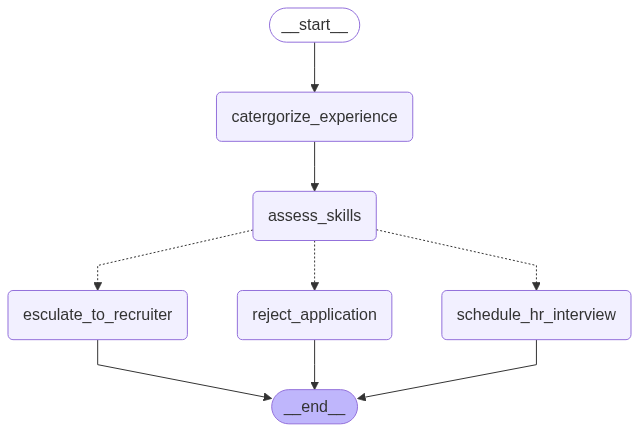

In [212]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("somethig went wrong")
    print("make sure that you compile before you viszulize this ")
    pass

In [213]:
def run_candidate_screening(application:str):
  results = app.invoke({"application":application})
  return {
      "experience_level":results["experience_level"],
      "skill":results["skill"],
      "response":results["response"]
  }


In [214]:
in_return = run_candidate_screening("i am a java developer with 1 year of experience ")

categorizing experience level :
Based on the job application, I would categorize the candidate as 'entry-level'.

The candidate has only 1 year of experience, which is a relatively short period of time in the industry. Typically, entry-level positions require little to no experience, and the candidate is expected to learn and grow in the role. In this case, the candidate has some experience, but it's still limited, which suggests they are still in the early stages of their career and would benefit from guidance and mentorship.
assessing skills :
skills Match :NoMatch
schedling hr interview 


In [216]:
candidate01 = run_candidate_screening("i am a python developer with 10 year of experience ")

categorizing experience level :
Based on the job application, I would categorize the candidate as 'senior-level'.

Here's why:

* 10 years of experience is a significant amount of time, indicating that the candidate has had a long and established career as a Python developer.
* With a decade of experience, the candidate is likely to have developed a deep understanding of Python and its ecosystem, as well as a strong track record of delivering projects and solving complex problems.
* Senior-level candidates typically have a high level of expertise, a strong portfolio of work, and a leadership or mentorship role in their previous organizations. While the application doesn't explicitly mention these qualities, the 10-year experience suggests that the candidate has likely developed these skills over time.

In contrast, entry-level candidates typically have little to no experience (0-2 years), while mid-level candidates have some experience (2-5 years) but may not have reached the same leve